In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from time import time
pixel_well_depth = 20000
numchannel = 1
batch_size = 32

In [2]:
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/positive_cropped.mat"
mal_dict = loadmat(path)
infected = mal_dict['stack']
path = "C:/Users/ameyc/Documents/deep-learning-microscopes/malaria/data/negative_cropped.mat"
wmal_dict = loadmat(path)
normal = wmal_dict['stack']
infected = np.moveaxis(infected, -1, 0)
normal = np.moveaxis(normal, -1, 0)

infected_train, infected_test = train_test_split(infected, test_size = 0.2)
normal_train, normal_test = train_test_split(normal, test_size = 0.2)
normal_train.shape

(580, 28, 28, 3)

In [3]:
def get_training_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_train//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_train//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.cast(tf.reduce_sum(
            tf.concat([x, y], axis=0), axis=0), tf.uint8), axis=-1, keepdims = True), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.reduce_sum(tf.cast(x, tf.uint8), axis=-1, keepdims=True), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.reduce_sum(tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), axis=-1, keepdims=True), [1,0]))
    dataset0 = dataset0.batch(16)
    
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

def get_testing_iterator(n = 0):
    infected_dataset = tf.data.Dataset.from_tensor_slices(infected_test//(n+1))
    normal_dataset = tf.data.Dataset.from_tensor_slices(normal_test//(n+1))
    
    if n > 0:
        infected_dataset = infected_dataset.shuffle(n+1).repeat().batch(1)
        normal_dataset1 = normal_dataset.shuffle(n+1).repeat().batch(n)
        dataset1 = tf.data.Dataset.zip((infected_dataset, normal_dataset1))
        dataset1 = dataset1.map(lambda x,y: (tf.reduce_sum(tf.cast(tf.reduce_sum(
            tf.concat([x, y], axis=0), axis=0), tf.uint8), axis=-1, keepdims = True), [0,1]))
        dataset1 = dataset1.batch(16)
    else:
        dataset1 = infected_dataset.repeat().map(lambda x: (tf.reduce_sum(tf.cast(x, tf.uint8), axis=-1, keepdims=True), [0,1]))
        dataset1 = dataset1.shuffle(17).batch(16)
    
    dataset0 = normal_dataset.shuffle(n+2).repeat().batch(n+1)
    dataset0 = dataset0.map(lambda x: (tf.reduce_sum(tf.cast(tf.reduce_sum(x, axis=0), tf.uint8), axis=-1, keepdims=True), [1,0]))
    dataset0 = dataset0.batch(16)
    
    iterator0 = dataset0.make_initializable_iterator()
    iterator1 = dataset1.make_initializable_iterator()
    
    return iterator0, iterator1

In [4]:
def get_batch(n, istrain):
    if istrain == 0:
        x0, y0 = train_it0.get_next()
        x1, y1 = train_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = add_noise(x)
        y = tf.concat([y0,y1], axis=0)
    else:
        x0, y0 = test_it0.get_next()
        x1, y1 = test_it1.get_next()
        x = tf.cast(tf.concat([x0,x1], axis=0), tf.float32)
        x = add_noise(x)
        y = tf.concat([y0,y1], axis=0)     
    return x, y

In [5]:
def add_noise(x):  
    noise = tf.random.normal(shape = tf.shape(x))
    noise = noise*tf.math.sqrt(x*(1-1/(n+1)/numchannel)*256/pixel_well_depth)
    x = tf.add(x, noise)
    return x

In [6]:
def pass_through_validation(sess, n = 0, numbatches = 50):
    val = 0
    for i in range(numbatches):
        val += sess.run(accuracy, feed_dict = {train_place: 1})
    return val/numbatches

In [7]:
def CNN2(net,labels,numcategories=10):
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=32, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='same', activation=tf.nn.relu)
    net = tf.layers.conv2d(net, filters=64, kernel_size=3, strides=2, activation=tf.nn.relu)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.Flatten()(net) #flatten for fc
    net = tf.layers.dense(net,1024)
    net = tf.contrib.layers.layer_norm(net)
    net = tf.layers.dense(net,numcategories)
    return net #return net to examine accuracy

In [8]:
acc = list()
fulls = time()
for n in range(15):
    tf.reset_default_graph() 
    sess = tf.Session()
    train_it0, train_it1 = get_training_iterator(n)
    test_it0, test_it1 = get_testing_iterator(n)
    train_place = tf.placeholder(tf.int8)
    images, label = get_batch(n, istrain=train_place)
    pred = CNN2(images, label, 2)
    loss = tf.losses.softmax_cross_entropy(logits=pred, onehot_labels=label)
    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
    prediction = tf.argmax(pred,1)
    truth = tf.argmax(label,1)
    accuracy = tf.reduce_mean(tf.to_float(tf.equal(prediction,truth)))
    
    Accuracy = list()
    for runs in range (10):
        sess.run(tf.global_variables_initializer())
        sess.run(train_it0.initializer)
        sess.run(train_it1.initializer)
        sess.run(test_it0.initializer)
        sess.run(test_it1.initializer)
        train_losses = list()
        val_losses = list()
        start=time()
        for i in range(251):
            _, tloss = sess.run([train_op, loss], feed_dict={train_place: 0})
            train_losses.append(tloss)
            if i%250==0:
                prediction = list()
                y_label = list()
                val_losses.append(pass_through_validation(sess, n, numbatches=20))
                print("iteration %d; batch classifier loss: %f; batch Validation accuracy: %f; Time passed in this loop: %.2f" % 
                      (i,train_losses[-1],val_losses[-1],time()-start))
        Accuracy.append(val_losses[-1])
    acc.append(Accuracy)
    sess.close()
fulle = time()

iteration 0; batch classifier loss: 0.835284; batch Validation accuracy: 0.500000; Time passed in this loop: 11.40
iteration 250; batch classifier loss: 0.002206; batch Validation accuracy: 1.000000; Time passed in this loop: 13.38
iteration 0; batch classifier loss: 1.218405; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.002466; batch Validation accuracy: 1.000000; Time passed in this loop: 2.01
iteration 0; batch classifier loss: 0.823599; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.001424; batch Validation accuracy: 1.000000; Time passed in this loop: 2.04
iteration 0; batch classifier loss: 0.813281; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.001015; batch Validation accuracy: 1.000000; Time passed in this loop: 2.06
iteration 0; batch classifier loss: 1.031588; batch Validation accuracy: 0.500

iteration 0; batch classifier loss: 0.984643; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 250; batch classifier loss: 0.195111; batch Validation accuracy: 0.920312; Time passed in this loop: 2.16
iteration 0; batch classifier loss: 1.372404; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.299102; batch Validation accuracy: 0.951562; Time passed in this loop: 2.16
iteration 0; batch classifier loss: 1.898379; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.107399; batch Validation accuracy: 0.903125; Time passed in this loop: 2.16
iteration 0; batch classifier loss: 1.862153; batch Validation accuracy: 0.500000; Time passed in this loop: 0.06
iteration 250; batch classifier loss: 0.193038; batch Validation accuracy: 0.917188; Time passed in this loop: 2.16
iteration 0; batch classifier loss: 0.703129; batch Validation accuracy: 0.50000

iteration 0; batch classifier loss: 0.819932; batch Validation accuracy: 0.500000; Time passed in this loop: 0.08
iteration 250; batch classifier loss: 0.625484; batch Validation accuracy: 0.845313; Time passed in this loop: 2.28
iteration 0; batch classifier loss: 0.669780; batch Validation accuracy: 0.500000; Time passed in this loop: 0.08
iteration 250; batch classifier loss: 0.250813; batch Validation accuracy: 0.867188; Time passed in this loop: 2.29
iteration 0; batch classifier loss: 0.906281; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 250; batch classifier loss: 0.293634; batch Validation accuracy: 0.862500; Time passed in this loop: 2.30
iteration 0; batch classifier loss: 0.768909; batch Validation accuracy: 0.500000; Time passed in this loop: 0.07
iteration 250; batch classifier loss: 0.382774; batch Validation accuracy: 0.882812; Time passed in this loop: 2.33
iteration 0; batch classifier loss: 0.815078; batch Validation accuracy: 0.50000

iteration 0; batch classifier loss: 1.517497; batch Validation accuracy: 0.500000; Time passed in this loop: 0.09
iteration 250; batch classifier loss: 0.320920; batch Validation accuracy: 0.845313; Time passed in this loop: 2.66
iteration 0; batch classifier loss: 1.026750; batch Validation accuracy: 0.500000; Time passed in this loop: 0.10
iteration 250; batch classifier loss: 0.412274; batch Validation accuracy: 0.818750; Time passed in this loop: 2.67
iteration 0; batch classifier loss: 0.881703; batch Validation accuracy: 0.500000; Time passed in this loop: 0.42
iteration 250; batch classifier loss: 0.316333; batch Validation accuracy: 0.812500; Time passed in this loop: 3.09
iteration 0; batch classifier loss: 0.712254; batch Validation accuracy: 0.500000; Time passed in this loop: 0.11
iteration 250; batch classifier loss: 0.485063; batch Validation accuracy: 0.823438; Time passed in this loop: 2.80
iteration 0; batch classifier loss: 0.801797; batch Validation accuracy: 0.50000

iteration 0; batch classifier loss: 1.207812; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 250; batch classifier loss: 0.514922; batch Validation accuracy: 0.825000; Time passed in this loop: 2.96
iteration 0; batch classifier loss: 1.688743; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 250; batch classifier loss: 0.313233; batch Validation accuracy: 0.828125; Time passed in this loop: 2.92
iteration 0; batch classifier loss: 0.672891; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 250; batch classifier loss: 0.598747; batch Validation accuracy: 0.814063; Time passed in this loop: 2.96
iteration 0; batch classifier loss: 0.760968; batch Validation accuracy: 0.500000; Time passed in this loop: 0.12
iteration 250; batch classifier loss: 0.433080; batch Validation accuracy: 0.828125; Time passed in this loop: 2.95
iteration 0; batch classifier loss: 2.559294; batch Validation accuracy: 0.50000

In [9]:
fulle - fulls

468.4552035331726

Text(0, 0.5, 'accuracy')

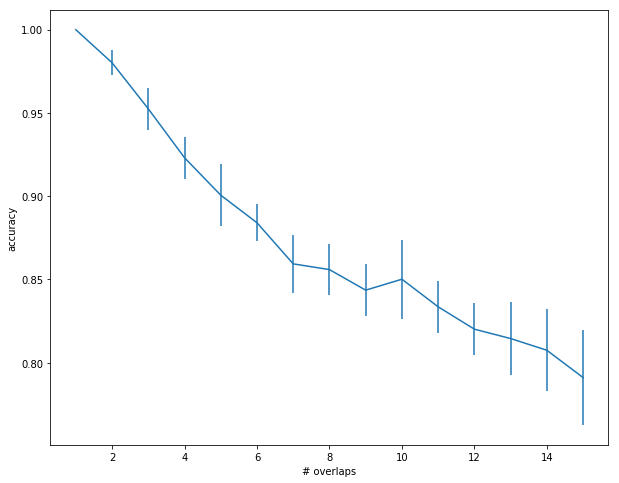

In [10]:
std = np.std(acc, axis=1)
mean = np.mean(acc, axis=1)
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(1,16), mean, yerr=[std, std])
plt.xlabel("# overlaps")
plt.ylabel("accuracy")

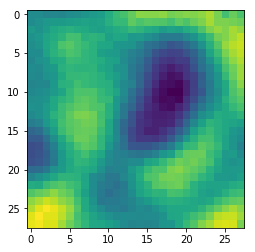

In [11]:
sess = tf.Session()
train_it0, train_it1 = get_training_iterator(n=4)
sess.run(tf.global_variables_initializer())
sess.run(train_it0.initializer)
sess.run(train_it1.initializer)
images, label = get_batch(n=4, istrain=0)
plt.imshow(sess.run(images)[19,:,:,0].astype(np.uint8))
sess.close()

In [12]:
np.save("accbase.npy",acc)